# Electromagnetics example
Authors: Hans Petter Langtangen and Anders Logg

Figure by: Jørgen S. Dokken

In this example, we will consider an iron cylinder with copper wires wound around the cylinder, as shown below

```{figure} wire.png
:name: cross-sections
```

Through the copper wires a static current of $J=1A$ is flowing.
We would like to compute the magnetic field $B$ in the iron cylinder, the copper wires, and the surrounding vaccum. 


We start by simplifying the problem to a 2D problem. We can do this by assuming that the cylinder extends far along the z-axis and as a consequence the field is virtually independent of the z-coordinate. Nesxt, we consder Maxwell's equation to derive a Poisson equation for the magnetic field (or rather its potential)
```{math}
\nabla \cdot D &= \rho,\\
\nabla \cdot B &= 0,\\
\nabla \times E &= -\frac{\partial B}{\partial t},\\
\nabla \times H &= \frac{\partial D}{\partial t}+ J.
```
Here, $D$ is the displacement field, $B$ is the magnetic field, $E$ is the electric field, and $H$ is the magnetizing field.
In addition to Maxwell's equation, we need a constitutive relation between $B$ and $H$,
```{math}
B =\mu H,
```
which holds for an isotropic linear magnetic medium. 
Here, $\mu$ is the magnetic permability of the material. 
Now, since $B$ is solenodial (divergence free) accoording to Maxwell's equations, we known that $B$ must be the curl of some vector field $A$. This field is called the magnetic vector potential. Since the problem is static and thus $\frac{\partial D}{\partial t}=0$, it follows that
```{math}
J = \nabla \times H = \nabla \times(\mu^{-1} B)=\nabla \times (\mu^{-1}\nabla \times A ) = -\nabla \cdot (\mu^{-1}\nabla A).
```
In the last step, we have expanded the second derivatives and used the gauge freedom of $A$ to simplify the equations to a simple vector-valued Poisson equation for the magnetic vector potential; if $B=\nabla \times A$, then $B=\nabla \times (A+\nabla \phi)$ for any scalar field $\phi$ (the gauge function).
For the current problem, we thus need to solve the following 2D Poisson problem for the $z$-component $A_z$ of the magnetic 
vector potential
```{math}
    - \nabla \cdot (\mu^{-1} \nabla A_z) &= J_z && \text{in } \mathbb{R}^2,\\
    \lim_{\vert(x,y)\vert\to \infty}A_z &= 0.&&
```
Since we cannot solve the problem on an infinite domain, we will truncate the domain using a large disk, and set $A_z=0$ on the boundary. The current $J_z$ is set to $+1$A in the interior set of the circles (copper-wire cross sections) and to $-1$ A in the exteriror set of circles in {ref}`cross-section`.
Once the magnetic field vector potential has been computed, we can compute the magnetic field $B=B(x,y)$ by
```{math}
    B(x,y)&=\left(\frac{\partial A_z}{\partial y}, - \frac{\partial A_z}{\partial x} \right).
```
The weak formulation is easily obtained by multiplication of a test function $v$, followed by integration by parts, where all boundary integrals vanishes due to the Dirichlet condition, we obtain $a(A_z,v)=L(v)$ with
```{math}
a(A_z, v)&=\int_\Omega \mu^{-1}\nabla A_z \cdot \nabla v ~\mathrm{d}x,\\
L(v)&=\int_\Omega J_z v~\mathrm{d} x.
```



## Meshing a complex structure with subdomains
Author: Jørgen S. Dokken

In this example, we will create a domain consisting of 

In [1]:
import gmsh
import numpy as np
from mpi4py import MPI

rank = MPI.COMM_WORLD.rank

gmsh.initialize()
r = 0.1   # Radius of copper wires
R = 5     # Radius of domain
a = 1     # Radius of inner iron cylinder
b = 1.2   # Radius of outer iron cylinder
N = 5     # Number of windings
c_1 = 0.8 # Radius of inner copper wires
c_2 = 1.4 # Radius of outer copper wires
gdim = 2  # Geometric dimension of the mesh
if rank == 0:

    # Define geometry for iron cylinder
    outer_iron = gmsh.model.occ.addCircle(0, 0, 0, b)
    inner_iron = gmsh.model.occ.addCircle(0, 0, 0, a)
    gmsh.model.occ.addCurveLoop([outer_iron], 5)
    gmsh.model.occ.addCurveLoop([inner_iron], 6)
    iron = gmsh.model.occ.addPlaneSurface([5, 6])
    gmsh.model.occ.synchronize()

    # Define geometry for background
    back = gmsh.model.occ.addCircle(0, 0, 0, R)
    gmsh.model.occ.addCurveLoop([back], 7)
    background = gmsh.model.occ.addPlaneSurface([7])
    gmsh.model.occ.synchronize()

    # Define the sub-wires

    angles_N = [i*2*np.pi/N for i in range(N)]
    angles_S = [(i+0.5)*2*np.pi/N for i in range(N)]
    wires_N = [gmsh.model.occ.addCircle(c_1*np.cos(v), c_1*np.sin(v), 0, r) for v in angles_N]
    w_N = []
    for wire in wires_N:
        loop = gmsh.model.occ.addCurveLoop([wire])
        w_N.append((2, gmsh.model.occ.addPlaneSurface([loop])))

    wires_S = [gmsh.model.occ.addCircle(c_2*np.cos(v), c_2*np.sin(v), 0, r) for v in angles_S]
    w_S = []
    for wire in wires_S:
        loop = gmsh.model.occ.addCurveLoop([wire])
        w_S.append((2, gmsh.model.occ.addPlaneSurface([loop])))
    gmsh.model.occ.synchronize()

    all_surfaces = [(2, iron)]
    all_surfaces.extend(w_S)
    all_surfaces.extend(w_N)
    whole_domain = gmsh.model.occ.fragment([(2, background)], all_surfaces)
    gmsh.model.occ.synchronize()

    inner_tag = 2
    outer_tag = 2 + N
    background_surfaces = []
    other_surfaces = []
    for domain in whole_domain[0]:
        com = gmsh.model.occ.getCenterOfMass(domain[0], domain[1])
        mass = gmsh.model.occ.getMass(domain[0], domain[1])
        # Identify iron circle by its mass
        if np.isclose(mass, np.pi*(b**2-a**2)):
            gmsh.model.addPhysicalGroup(domain[0], [domain[1]], tag=1)
            other_surfaces.append(domain)
        # Identify the background circle by its center of mass
        elif np.allclose(com, [0, 0, 0]):
            background_surfaces.append(domain[1])

        # Identify the inner circles by their center of mass
        elif np.isclose(np.linalg.norm(com), c_1):
            gmsh.model.addPhysicalGroup(domain[0], [domain[1]], inner_tag)
            inner_tag +=1
            other_surfaces.append(domain)
        # Identify the outer circles by their center of mass
        elif np.isclose(np.linalg.norm(com), c_2):
            gmsh.model.addPhysicalGroup(domain[0], [domain[1]], outer_tag)
            outer_tag +=1
            other_surfaces.append(domain)
    gmsh.model.addPhysicalGroup(2, background_surfaces, tag=0)
    gmsh.model.mesh.field.add("Distance", 1)
    edges = gmsh.model.getBoundary(other_surfaces)
    gmsh.model.mesh.field.setNumbers(1, "EdgesList", [e[1] for e in edges])
    gmsh.model.mesh.field.add("Threshold", 2)
    gmsh.model.mesh.field.setNumber(2, "IField", 1)
    gmsh.model.mesh.field.setNumber(2, "LcMin", r / 2)
    gmsh.model.mesh.field.setNumber(2, "LcMax", 12 * r)
    gmsh.model.mesh.field.setNumber(2, "DistMin", 2 * r)
    gmsh.model.mesh.field.setNumber(2, "DistMax", 4 * r)
    gmsh.model.mesh.field.setAsBackgroundMesh(2)
    gmsh.option.setNumber("Mesh.Algorithm", 7)
    gmsh.model.mesh.generate(gdim)
    gmsh.write("mesh2.msh")

As in [the Navier-Stokes tutorial](../chapter2/ns_code2) we load the mesh directly into dolfin-X, without writing it to file. This time, we create `MeshTags` for the physical cell data.

In [2]:
from dolfinx.io import extract_gmsh_geometry, extract_gmsh_topology_and_markers, ufl_mesh_from_gmsh
from dolfinx.cpp.io import perm_gmsh, extract_local_entities
from dolfinx.cpp.mesh import to_type, cell_entity_type
from dolfinx.cpp.graph import AdjacencyList_int32
from dolfinx.mesh import create_meshtags, create_mesh
if rank == 0:
    # Get mesh geometry
    x = extract_gmsh_geometry(gmsh.model)

    # Get mesh topology for each element
    topologies = extract_gmsh_topology_and_markers(gmsh.model)
    # Get information about each cell type from the msh files
    num_cell_types = len(topologies.keys())
    cell_information = {}
    cell_dimensions = np.zeros(num_cell_types, dtype=np.int32)
    for i, element in enumerate(topologies.keys()):
        properties = gmsh.model.mesh.getElementProperties(element)
        name, dim, order, num_nodes, local_coords, _ = properties
        cell_information[i] = {"id": element, "dim": dim, "num_nodes": num_nodes}
        cell_dimensions[i] = dim

    # Sort elements by ascending dimension
    perm_sort = np.argsort(cell_dimensions)

    # Broadcast cell type data and geometric dimension
    cell_id = cell_information[perm_sort[-1]]["id"]
    tdim = cell_information[perm_sort[-1]]["dim"]
    num_nodes = cell_information[perm_sort[-1]]["num_nodes"]
    cell_id, num_nodes = MPI.COMM_WORLD.bcast([cell_id, num_nodes], root=0)

    cells = topologies[cell_id]["topology"]
    cell_values = topologies[cell_id]["cell_data"]
else:
    cell_id, num_nodes = MPI.COMM_WORLD.bcast([None, None], root=0)
    cells, x = np.empty([0, num_nodes]), np.empty([0, gdim])
    cell_values = np.empty((0,))
gmsh.finalize()

We now distribute the mesh over multiple processors

In [3]:
# Create distributed mesh
ufl_domain = ufl_mesh_from_gmsh(cell_id, gdim)
gmsh_cell_perm = perm_gmsh(to_type(str(ufl_domain.ufl_cell())), num_nodes)
cells = cells[:, gmsh_cell_perm]
mesh = create_mesh(MPI.COMM_WORLD, cells, x[:, :gdim], ufl_domain)
tdim = mesh.topology.dim

local_entities, local_values = extract_local_entities(
            mesh, tdim, cells, cell_values)
mesh.topology.create_connectivity(tdim, 0)
adj = AdjacencyList_int32(local_entities)
ct = create_meshtags(mesh, tdim, adj, np.int32(local_values))

In [4]:
import dolfinx.io
with dolfinx.io.XDMFFile(MPI.COMM_WORLD, "mt.xdmf", "w") as xdmf:
    xdmf.write_mesh(mesh)
    xdmf.write_meshtags(ct)

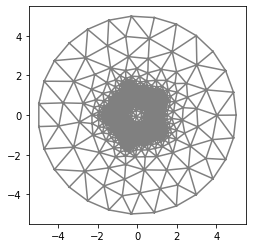